# Moho of South America

This notebook applies the proposed gravity inversion method to estimate the Moho of South America. We'll use the same cross-validation methods presented in the [synthetic-crust1.ipynb](synthetic-crust1.ipynb) notebook to determined the optimal regularization parameter, density contrast, and reference height.

The data used here was downloaded from the [ICGEM web service](http://icgem.gfz-potsdam.de/ICGEM/) and processes in the [process-sam-gravity-data.ipynb](process-sam-gravity-data.ipynb) notebook.

## Package imports

Load the necessary libraries to run the inversion and make graphs.

In [1]:
# Insert the plots into the notebook
%matplotlib inline

Load the standard scientific Python stack to numerical analysis and plotting.

In [2]:
from __future__ import division
import datetime
import zipfile
import cPickle as pickle
import itertools
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import multiprocessing
import seaborn  # Makes the default style of the plots nicer

The computations generate a lot of run-time warnings. They aren't anything to be concerned about so disable them to avoid clutter.

In [3]:
import warnings
warnings.simplefilter('ignore')

Load the required modules from [Fatiando a Terra](http://www.fatiando.org).

In [4]:
from fatiando.vis import mpl
from fatiando.gravmag import tesseroid
from fatiando import gridder, utils
from fatiando.inversion import Smoothness2D
import fatiando

In [5]:
print("Version of Fatiando a Terra used: {}".format(fatiando.__version__))

Version of Fatiando a Terra used: 237ba1dd35d47ea0a5e286781faddfe60ab4d12d


Load our custom classes and functions.

In [6]:
from datasets import fetch_assumpcao_moho_points
from mohoinv import (MohoGravityInvSpherical, TesseroidRelief, make_mesh,
                     split_data, score_test_set, score_seismic_constraints, 
                     score_all, fit_all, predict_seismic)

Get the number of cores in this computer to run the some things in parallel.

In [7]:
ncpu = multiprocessing.cpu_count()
print("Number of cores: {}".format(ncpu))

Number of cores: 8


## Load the gravity data

Load the processed gravity anomaly data.

In [8]:
with open('../data/processed-goco5s-data-sam-h50km.txt') as f:
    for i in range(3):  # Skip the first 2 header lines
        line = f.readline()
    full_shape = [int(x) for x in line.split()[1:]]
    full_lat, full_lon, full_height, full_grav = np.loadtxt(f, usecols=[0, 1, 2, -1], unpack=True)
    full_data = [full_lat, full_lon, full_height, full_grav]
print('Number of data points in lat and lon: {}'.format(full_shape))

Number of data points in lat and lon: [401, 301]


This is the full dataset. We'll use a portion of it for the inversion and the rest for [cross-validation](#Cross-validation). 

Make a plot the data.

In [9]:
full_area = (full_lat.min(), full_lat.max(), full_lon.min(), full_lon.max())
bm = Basemap(projection='cyl', 
             llcrnrlon=full_area[2], urcrnrlon=full_area[3], 
             llcrnrlat=full_area[0], urcrnrlat=full_area[1],
             resolution='l')

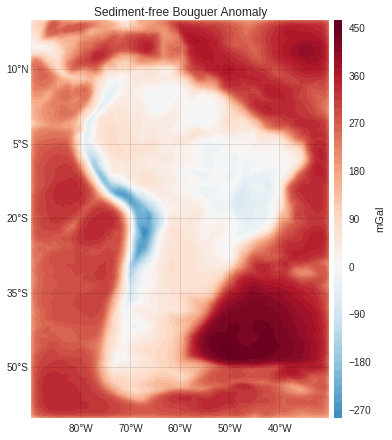

In [10]:
x, y = bm(full_lon, full_lat)
ranges = np.abs([full_grav.min(), full_grav.max()]).max()

plt.figure(figsize=(7, 6))
plt.title('Sediment-free Bouguer Anomaly')
bm.contourf(x, y, full_grav, 60, tri=True, cmap='RdBu_r', vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=50).set_label('mGal')
bm.drawmeridians(np.arange(-80, -30, 10), labels=[0, 0, 0, 1], linewidth=0.2)
bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0.2)
plt.tight_layout()

## Cross-validation

The inversion will use only a portion of the data for inversion. The rest will be used for cross-validation to determine an optimal regularization parameter.

We'll use the `split_data` function from [mohoinv.py](mohoinv.py) to separate the dataset into the two parts by taking every other 2 points for inversion and keeping the rest for cross-validation (testing). 

In [11]:
inversion_set, test_set, shape = split_data(full_data, full_shape, every_other=2)

print("Number of inversion grid points: {} x {} = {}".format(shape[0], shape[1], shape[0]*shape[1]))
print("Number of test set points: {}".format(test_set[0].size))

Number of inversion grid points: 201 x 151 = 30351
Number of test set points: 90350


Plot the inversion data set.

In [12]:
lat, lon, height, data = inversion_set

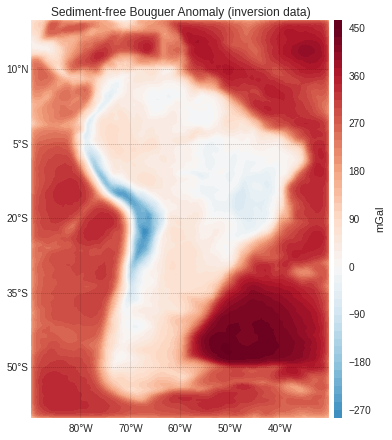

In [13]:
x, y = bm(lon, lat)
ranges = np.abs([data.min(), data.max()]).max()

plt.figure(figsize=(7, 6))
plt.title('Sediment-free Bouguer Anomaly (inversion data)')
bm.contourf(x, y, data, 60, tri=True, cmap='RdBu_r', vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=50).set_label('mGal')
bm.drawmeridians(np.arange(-80, -30, 10), labels=[0, 0, 0, 1], linewidth=0.2)
bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0.2)
plt.tight_layout()

Load the seismic point constraints. This is used in cross-validation to find the reference level and the density contrast.

In [14]:
test_points = fetch_assumpcao_moho_points('../data/Moho_Map_SAm2013_data.tar.gz', 
                                          todepth=True, return_height=False)[:-1]

The longitude for the seismic points is in the range [-180, 180] but we need it in [0, 360] because of the gravity data.

In [15]:
test_points[1] += 360

Plot the seismic points.

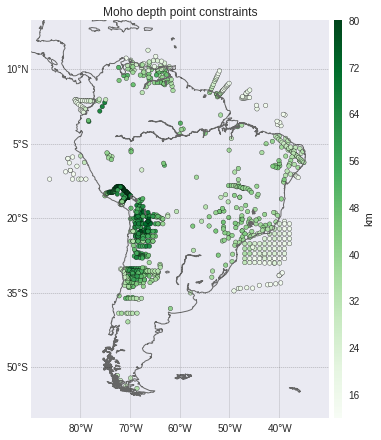

In [16]:
x, y = bm(test_points[1], test_points[0])

plt.figure(figsize=(7, 6))
plt.title('Moho depth point constraints')
bm.scatter(x, y, c=-0.001*test_points[-1], s=20, cmap='Greens')
plt.colorbar(pad=0.01, aspect=50).set_label('km')
bm.drawmeridians(np.arange(-80, -30, 10), labels=[0, 0, 0, 1], linewidth=0.2)
bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0.2)
bm.drawcoastlines(color="#666666")
plt.tight_layout()

## Inversion setup

Create the objects and configuration that we'll need to run the inversions.

We need to generate a `TesseroidRelief` mesh for the inversion, give it a reference level and a density contrast.

In [17]:
area = (lat.min(), lat.max(), lon.min(), lon.max())
mesh = make_mesh(area, shape)

We'll also need an initial estimate, the solver and its configuration, and a regularization object.

In [18]:
misfit = MohoGravityInvSpherical(lat, lon, height, data, mesh)
regul = Smoothness2D(mesh.shape)
initial = -60e3*np.ones(mesh.size)  # The initial estimate doesn't really matter too much

## Plotting functions

We'll define some plotting functions here to avoid having all this code down with the results. You can safely skip (not read) this section because we only define the functions here. They are called after the inversion below.

In [19]:
def plot_fit(lat, lon, data, solution, bm):    
    ranges = np.abs([data.max(), data.min()]).max()
    
    plt.figure(figsize=(7, 6))
    plt.title('Observed (color) and predicted (contour) data')    
    levels = mpl.contourf(lon, lat, data, shape, 40, cmap='RdBu_r', basemap=bm, 
                          vmin=-ranges, vmax=ranges)
    plt.colorbar(pad=0.01).set_label('mGal')
    mpl.contour(lon, lat, solution[0].predicted(), shape, levels, 
                basemap=bm, color='#333333')
    bm.drawmeridians(np.arange(-80, -30, 10), labels=[0, 0, 0, 1], linewidth=0.2)
    bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0.2)
    plt.tight_layout(pad=0)
    
def plot_residuals(solution):
    residuals = solution[0].residuals()
    
    plt.figure(figsize=(3, 2.5))
    plt.text(0.65, 0.8, 
             "mean = {:.2f}\nstd = {:.2f}".format(residuals.mean(), residuals.std()), 
             transform=plt.gca().transAxes)
    plt.hist(residuals, bins=20, normed=True, histtype='stepfilled')
    plt.xlabel('Residuals (mGal)')
    plt.ylabel('Normalized frequency')
    plt.tight_layout(pad=0)
    
def plot_estimate(solution, bm):
    moho = solution.estimate_
    x, y = bm(moho.lons, moho.lats)
    
    plt.figure(figsize=(7, 6))
    plt.title("Estimated Moho depth")
    bm.pcolormesh(x, y, -0.001*moho.relief.reshape(moho.shape), cmap='Greens')
    plt.colorbar(pad=0.01).set_label('km')
    bm.drawmeridians(np.arange(-80, -30, 10), labels=[0, 0, 0, 1], linewidth=0.2)
    bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0.2)
    plt.tight_layout(pad=0)
    
def plot_diff_seismic(solution, test_points, bm):
    moho = solution.estimate_
    x, y = bm(moho.lons, moho.lats)
    diff = -0.001*(test_points[-1] - predict_seismic(moho, *test_points[:2]))
    ranges = np.abs([diff.max(), diff.min()]).max()
    lat, lon, depth = test_points
    xp, yp = bm(lon, lat)
   
    fig = plt.figure(figsize=(7, 6))
    bm.pcolormesh(x, y, -0.001*moho.relief.reshape(moho.shape), cmap='Greens')
    plt.colorbar(pad=0.01, aspect=50).set_label('Estimated Moho depth (km)')
    bm.scatter(xp, yp, c=diff, s=40, cmap='PuOr_r', 
                     vmin=-ranges, vmax=ranges, linewidths=0.1)
    cb = plt.colorbar(pad=0.01, aspect=50)
    cb.set_label('Difference between seismic and estimated (km)')
    bm.drawmeridians(np.arange(-80, -30, 10), labels=[0, 0, 1, 0], linewidth=0.2)
    bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0.2)
    plt.tight_layout(pad=0)
    
def plot_diff_seismic_hist(solution, test_points):
    moho = solution.estimate_
    diff = -0.001*(test_points[-1] - predict_seismic(moho, *test_points[:2]))

    plt.figure(figsize=(3, 2.5))
    plt.title('Difference (seismic points)')
    plt.text(0.65, 0.8, 
             "mean = {:.2f}\nstd = {:.2f}".format(diff.mean(), diff.std()), 
             transform=plt.gca().transAxes)
    # Use the line above so the text coordinates are in axes coordinates (0 to 1)
    # instead of data coordinates, which may vary between runs.
    plt.hist(diff, bins=20, normed=True, histtype='stepfilled')
    plt.xlabel('Differences (km)')
    plt.ylabel('Normalized frequency')
    plt.tight_layout(pad=0)
    
def plot_cv_regul(regul_params, scores, best, log=True): 
    plt.figure(figsize=(5, 3))
    plt.title('Cross-validation (regularization parameter)')
    plt.plot(regul_params, scores, marker='o')
    plt.plot(regul_params[best], scores[best], 's', markersize=10, 
             color=seaborn.color_palette()[2], label='Minimum')
    plt.legend(loc='upper left')
    plt.xscale('log')
    if log:
        plt.yscale('log')
    plt.xlabel('Regularization parameter')
    plt.ylabel(u'Mean Square Error')
    plt.tight_layout(pad=0)
    
def plot_cv_ref_dens(densities, reference_levels, scores, best_dens, best_ref):
    plt.figure(figsize=(5, 3))
    plt.title('Cross-validation (reference level and density)')
    plt.contourf(-0.001*reference_levels, densities, scores, 30, cmap='BuPu_r')
    plt.colorbar(pad=0.01).set_label('Mean Square Error')
    plt.plot(-0.001*reference_levels[best_ref], densities[best_dens], 's', markersize=10, 
             color=seaborn.color_palette()[2], label='Minimum')
    l = plt.legend(loc='upper left')
    for txt in l.get_texts():
        txt.set_color('#ffffff')
    plt.xlabel('Reference level (km)')
    plt.ylabel(u'Density contrast (kg/m³)')
    plt.tight_layout(pad=0)
    
def plot_convergence(solution, log=True):
    plt.figure(figsize=(5, 3))
    plt.title('Convergence')
    plt.plot(range(solution.stats_['iterations'] + 1), solution.stats_['objective'])
    plt.xlabel('Iteration')
    plt.ylabel('Goal function')
    if log:
        plt.yscale('log')
    plt.tight_layout(pad=0)

## Run the inversion and cross-validation

We'll keep the results in a Python dictionary (`dict`) along with all configuration and other metadata. We can then save this dict to a Pickle file and have inversion information saved with the results.

In [20]:
results = dict()

Save the configuration for the solver. We'll use the Gauss-Newton formulation of the inversion.

In [21]:
results['config'] = dict(method='newton', initial=initial, tol=0.2, maxit=6)

First, define the values of the regularization parameter, reference level, and density that we want to test during cross-validation.

In [22]:
results['regul_params'] = np.logspace(-10, -2, 16)
results['regul_params']

array([  1.00000000e-10,   3.41454887e-10,   1.16591440e-09,
         3.98107171e-09,   1.35935639e-08,   4.64158883e-08,
         1.58489319e-07,   5.41169527e-07,   1.84784980e-06,
         6.30957344e-06,   2.15443469e-05,   7.35642254e-05,
         2.51188643e-04,   8.57695899e-04,   2.92864456e-03,
         1.00000000e-02])

In [23]:
results['reference_levels'] = np.arange(-40e3, -20e3 + 1, 2500)
results['reference_levels']

array([-40000., -37500., -35000., -32500., -30000., -27500., -25000.,
       -22500., -20000.])

In [24]:
results['densities'] = np.arange(200, 500 + 1, 50)
results['densities']

array([200, 250, 300, 350, 400, 450, 500])

First, run the cross-validation to find the regularization parameter. We'll use one of the values for the reference and density contrast. The value of the regularization parameter that we estimate here will be used in the second cross-validation to find the density contrast and reference level.

In [25]:
misfit.set_density(results['densities'][-1]).set_reference(results['reference_levels'][-1])

Run the inversion for each value in `regul_params` (in parallel using all available cores). 

In [26]:
solvers = [(misfit + mu*regul).config(**results['config']) 
           for mu in results['regul_params']]

%time solutions = fit_all(solvers, njobs=ncpu)

CPU times: user 30.7 s, sys: 6.52 s, total: 37.2 s
Wall time: 8h 29min 8s


Keep only the estimated models in the results dict instead of the whole solvers to reduce the size of the pickle file. We can calculate the predicted data, etc, from the model only.

In [27]:
results['models_regul'] = [s.estimate_ for s in solutions]

Save these intermediate results in case something happens. This way we can resume computations from this point.

In [28]:
def pickle_results(results, intermediate=False):
    now = datetime.datetime.utcnow().strftime('%d %B %Y %H:%M:%S UTC')
    results['metadata'] = "Generated by south-america-moho.ipynb on {date}".format(date=now)
    if intermediate:
        fname = 'results/south-america-moho.intermediate.pickle'
    else:
        fname = 'results/south-america-moho.pickle'
    with open(fname, 'w') as f:
        pickle.dump(results, f)

In [29]:
pickle_results(results, intermediate=True)

Score the results against the test dataset.

In [30]:
%time results['scores_regul'] = score_all(results['models_regul'], test_set, points=False, njobs=ncpu)

CPU times: user 12.4 s, sys: 2.66 s, total: 15.1 s
Wall time: 3h 24min 26s


The best solution is the one with the smallest cross-validation score.

In [31]:
best_regul = np.argmin(results['scores_regul'])
results['best_regul'] = best_regul

We'll use this solution as the inversion solver for the next cross-validation (for the reference level and density).

In [32]:
results['solution_regul'] = solutions[best_regul]

Save the intermediate results again.

In [33]:
pickle_results(results, intermediate=True)

Take a look at the current solution. Plot the cross-validation scores, the inversion residuals, and the estimated solution.

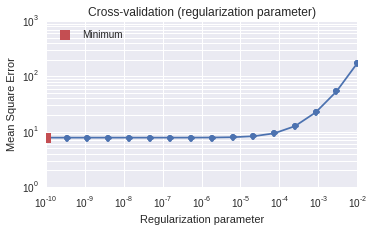

In [34]:
plot_cv_regul(results['regul_params'], results['scores_regul'], 
              best_regul, log=True)
plt.grid(True, which='both', axis='y')

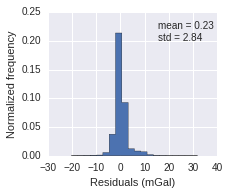

In [35]:
plot_residuals(results['solution_regul'])

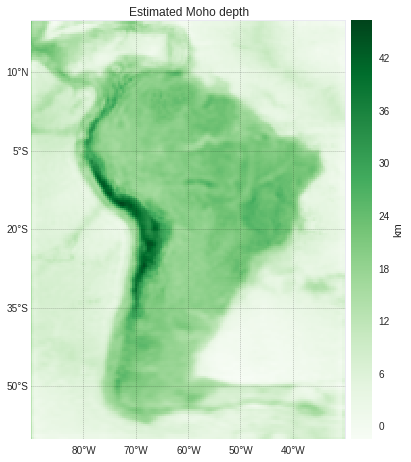

In [36]:
plot_estimate(results['solution_regul'], bm)

Run the second cross-validation to estimate the density-contrast and the reference level.

In [37]:
def set_ref_dens(solver, ref, dens):
    """
    Configure the solver to use this reference level and density.
    """
    res = solver.copy(deep=True)
    # res is a multi-objective with the misfit function + regularization
    # res[0] is the misfit (our inversion class)
    # res[1] is the Smoothness2D instance
    res[0].set_density(dens).set_reference(ref)
    return res

In [38]:
solvers = [set_ref_dens(results['solution_regul'], ref, dens) 
           for dens in results['densities'] 
           for ref in results['reference_levels']]

%time solutions = fit_all(solvers, njobs=ncpu)

CPU times: user 1min 58s, sys: 26.3 s, total: 2min 24s
Wall time: 1d 8h 33min 59s


Keep the only the estimated models in the results dict.

In [39]:
results['models_refdens'] = [s.estimate_ for s in solutions]

Score the estimates against the seismic constraints.

In [40]:
# Reshape the scores array because it should be a matrix 
# with density as the rows and reference level as the columns.
# This will make it easier for us to find the best density and reference level below.
cv_shape = (len(results['densities']), len(results['reference_levels']))
results['scores_refdens'] = score_all(results['models_refdens'], 
                                      test_points, points=True).reshape(cv_shape)

In [41]:
best = np.nanargmin(results['scores_refdens'])
# Find the index in reference_levels and densities corresponding to best
results['best_dens'], results['best_ref'] = np.unravel_index(best, cv_shape)
results['solution'] = solutions[best]

Print the estimated parameters:

In [42]:
estimated_ref = results['reference_levels'][results['best_ref']]
estimated_dens = results['densities'][results['best_dens']]
estimated_regul = results['regul_params'][results['best_regul']]
print('Cross-validation results:')
print(u'  reference level: {} km'.format(-0.001*estimated_ref))
print(u'  density contrast: {} kg/m³'.format(estimated_dens))
print(u'  regularization parameter: {}'.format(estimated_regul))

Cross-validation results:
  reference level: 35.0 km
  density contrast: 400 kg/m³
  regularization parameter: 1e-10


## Save the results

Save the final results into a pickle file.

In [43]:
pickle_results(results, intermediate=False)

Since the resulting pickle file will be large, we'll store it in a `zip` archive.

In [44]:
fname = 'south-america-moho'
pickle_file = '{}.pickle'.format(fname)
# Zip the pickle file
zipargs = dict(mode='w', compression=zipfile.ZIP_DEFLATED)
with zipfile.ZipFile('results/{}.zip'.format(fname), **zipargs) as f:
    f.write('results/{}'.format(pickle_file), arcname=pickle_file)

The zip file is still too large for [Github](https://github.com/) (maximum allowed is 50 Mb). The way to store and commit the file is to split it into two with the `split` command-line program. We can assemble the two parts again using the `cat` program (see [paper-figures.ipynb](paper-figures.ipynb) for an example).

In [54]:
%%bash
cd results/
split -b 30M --numeric-suffixes=1 south-america-moho.zip south-america-moho.zip.part
cd ..

Also save the estimated Moho to a text file in xyz format for portability.

In [45]:
now = datetime.datetime.utcnow().strftime('%d %B %Y %H:%M:%S UTC')
moho = results['solution'].estimate_
header = """# Moho of South America estimated by gravity data inversion
# See the source code for the inversion at:
#   https://github.com/pinga-lab/paper-moho-inversion-tesseroids
# Generated by south-america-moho.ipynb on {date}
# Model grid shape (nlat, nlon):
#   {nlat} {nlon}
# Latitude and longitude values correspond to the center of each
# model cell.
# Moho depth is provided in meters.
# Columns:
# lat lon Moho_depth
""".format(date=now, nlat=moho.shape[0], nlon=moho.shape[1])
with open('../model/south-american-moho.txt', 'w') as f:
    f.write(header)
    np.savetxt(f, np.c_[moho.clat.ravel(), moho.clon.ravel(), -moho.relief],
               fmt='%.5f')

## Make quick plots of the results

Make plots of the second cross-validation and the estimated Moho.

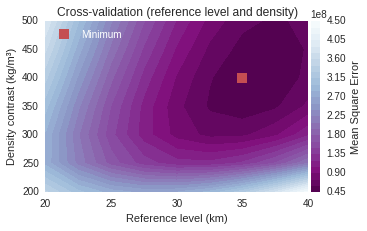

In [46]:
plot_cv_ref_dens(results['densities'], results['reference_levels'], 
                 results['scores_refdens'], results['best_dens'], 
                 results['best_ref'])

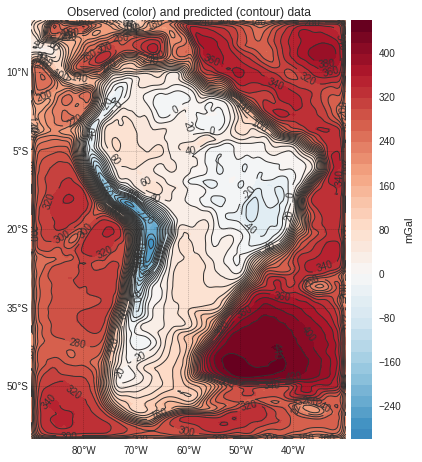

In [47]:
plot_fit(lat, lon, data, results['solution'], bm)

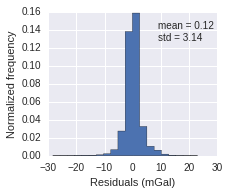

In [48]:
plot_residuals(results['solution'])

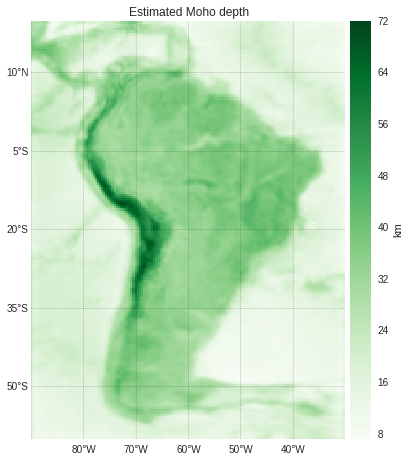

In [49]:
plot_estimate(results['solution'], bm)

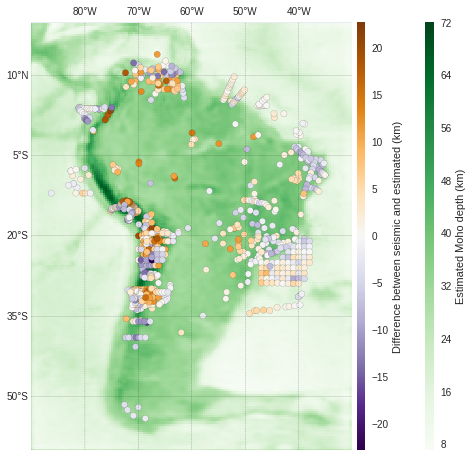

In [50]:
plot_diff_seismic(results['solution'], test_points, bm)

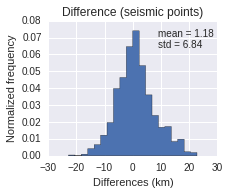

In [51]:
plot_diff_seismic_hist(results['solution'], test_points)

[]()